In [283]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap
from torch.distributions import Distribution, Uniform, Normal
import pyccl as ccl
from matplotlib.cm import get_cmap

In [284]:
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/pinocchio_data_vector/data_vector_pinocchio_mock_0.pkl' , allow_pickle= True )

In [285]:
pinocchio_mock['richness_bins']

[[19.999999999999996, 29.355985352441387],
 [29.355985352441387, 43.08869380063767],
 [43.08869380063767, 63.245553203367585],
 [63.245553203367585, 92.83177667225554],
 [92.83177667225554, 136.25841381159228],
 [136.25841381159228, 199.99999999999991]]

In [286]:
pinocchio_mock['count_richness_redshift'].T

array([[2556., 2640., 1820., 1035.,  535.,  210.],
       [4138., 3945., 2705., 1535.,  707.,  314.],
       [4556., 4301., 2976., 1612.,  690.,  270.],
       [4122., 3882., 2512., 1360.,  541.,  195.],
       [3217., 3021., 1946.,  954.,  405.,  143.]])

In [287]:
10**np.linspace( np.log10( 20 ) , np.log10( 200 ) , 6 )

array([ 20.        ,  31.69786385,  50.23772863,  79.62143411,
       126.1914689 , 200.        ])

In [288]:
richness_cents = np.array( [ ( 20 + 29.35 )/2. , ( 29.355 + 43.1 )/2. , ( 43.1 + 63.25 )/2. , ( 63.25 + 92.8 )/2. , ( 92.8 + 136.25 )/2. , ( 137.25 + 200 )/2.])

In [289]:
richness_cents

array([ 24.675 ,  36.2275,  53.175 ,  78.025 , 114.525 , 168.625 ])

In [290]:
pinocchio_mock

{'count_richness_redshift': array([[2556., 4138., 4556., 4122., 3217.],
        [2640., 3945., 4301., 3882., 3021.],
        [1820., 2705., 2976., 2512., 1946.],
        [1035., 1535., 1612., 1360.,  954.],
        [ 535.,  707.,  690.,  541.,  405.],
        [ 210.,  314.,  270.,  195.,  143.]]),
 'richness_bins': [[19.999999999999996, 29.355985352441387],
  [29.355985352441387, 43.08869380063767],
  [43.08869380063767, 63.245553203367585],
  [63.245553203367585, 92.83177667225554],
  [92.83177667225554, 136.25841381159228],
  [136.25841381159228, 199.99999999999991]],
 'redshift_bins': [[0.2, 0.36],
  [0.36, 0.52],
  [0.52, 0.6799999999999999],
  [0.6799999999999999, 0.8400000000000001],
  [0.8400000000000001, 1.0]],
 'log10Mass_bin': [[14.3, 14.600000000000001],
  [14.600000000000001, 14.9],
  [14.9, 15.2],
  [15.2, 15.5]],
 'count_mass_redshift': array([[6.075e+03, 9.440e+03, 1.007e+04, 8.926e+03, 6.716e+03],
        [1.650e+03, 2.197e+03, 2.102e+03, 1.584e+03, 9.730e+02],
        

In [291]:
pinocchio_mock['count_richness_redshift'][i]

array([535., 707., 690., 541., 405.])

(13.7, 15.0)

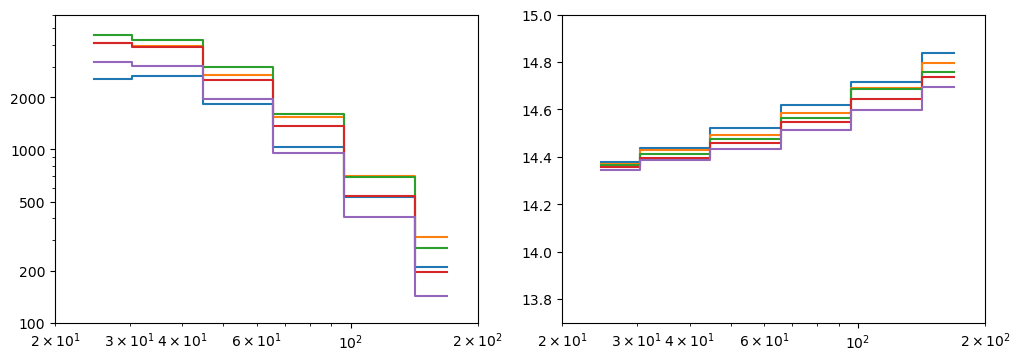

In [292]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)

for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    plt.plot( richness_cents , 
              pinocchio_mock['count_richness_redshift'].T[i] , drawstyle = 'steps-mid')

plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 100 , 6000 )

plt.subplot(122)

for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    plt.plot( richness_cents , 
              np.log10( pinocchio_mock['mean_mass_richness_redshift'].T[i] ) , drawstyle = 'steps-mid')

plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )

In [293]:
pinocchio_mock['redshift_bins']

[[0.2, 0.36],
 [0.36, 0.52],
 [0.52, 0.6799999999999999],
 [0.6799999999999999, 0.8400000000000001],
 [0.8400000000000001, 1.0]]

In [294]:
richness_bins = np.array( [ 20 , 29.35 , 43.1 , 63.2 , 92.83 , 136.26 , 200 ])
redshift_bins = np.array( [ 0.2 , 0.36 , 0.52 , 0.68 , 0.84 , 1.0 ])

In [295]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator_pl.selection_richness = 0
stacked_simulator_pl.dOmega = 0.25 * 4*np.pi
stacked_simulator_pl.richness_bins = richness_bins
stacked_simulator_pl.redshift_bins = redshift_bins
stacked_simulator_pl.sigma_mwl = 0.3
stacked_simulator_pl.include_mwl_measurement_errors = False
#stacked_simulator_pl.mwl_std = mwl_std
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'power law' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.05 ) , 
                               log10m_bins=  np.arange( 14.2 , 16, 0.01))
stacked_simulator_pl.hmf = ccl.halos.MassFuncDespali16(mass_def='vir')

In [296]:
# stacked_simulator_hm = simulation.Universe_simulation( 'stacked_counts' ,
#                                                     variable_params=['omega_m', 
#                                                                      'sigma_8', 
#                                                                      'h',
#                                                                      'alpha' , 
#                                                                      'B' ,
#                                                                      'log10Mmin',
#                                                                      'sigma' ],
#                                                     fixed_params={'w_0': -1, 'w_a': 0 } )
# stacked_simulator_hm.selection_richness = 0
# stacked_simulator_hm.dOmega = 0.25 * 4*np.pi
# stacked_simulator_hm.richness_bins = richness_bins
# stacked_simulator_hm.redshift_bins = redshift_bins
# stacked_simulator_hm.sigma_mwl = 0.3
# stacked_simulator_hm.include_mwl_measurement_errors = False
# #stacked_simulator_hm.mwl_std = mwl_std
# stacked_simulator_hm.correlation_mass_evolution = False
# stacked_simulator_hm.set_richness_mass_relation( 'halo model' )
# stacked_simulator_hm.set_bins( z_bins = np.arange( 0.2 , 1 , 0.05 ) , 
#                                log10m_bins=  np.arange( 14.2 , 16, 0.01))
# stacked_simulator_hm.hmf = ccl.halos.MassFuncDespali16(mass_def='vir')

In [297]:
# Define individual priors with correct tensor shape
prior_om = Uniform(torch.tensor([0.05]), torch.tensor([1.0]))
prior_s8 = Uniform(torch.tensor([0.5]), torch.tensor([1.5]))
prior_h = Normal(torch.tensor([0.7]), torch.tensor([0.1]))  # Normal prior on h
prior_alpha = Uniform(torch.tensor([0.4]), torch.tensor([1.2]))
prior_c = Uniform(torch.tensor([1.0]), torch.tensor([5.0]))
prior_beta = Uniform(torch.tensor([-5.0]), torch.tensor([5.0]))
prior_sigma = Uniform(torch.tensor([0.05]), torch.tensor([0.5]))

# Combine the priors into a list for processing
priors = [ prior_om, prior_s8, prior_h, prior_alpha, prior_c , prior_beta , prior_sigma ]

In [365]:
sim_obs = stacked_simulator_pl.run_simulation( torch.Tensor([ 0.25 , 0.8 , 0.7 , 0.85 , 2.8 , 0.2 , 0.4 ]))

In [366]:
# stacked_simulator_pl._get_parameter_set( torch.Tensor([ 0.3 , 0.8 , 0.7 , 1 , 3. , 0.1 ]) )

In [367]:
# # infer posteriors
# pinocchio_posterior = infer( stacked_simulator_pl.run_simulation , 
#                              priors, 
#                              method = 'SNPE', 
#                              num_simulations = 1000 , 
#                              num_workers = 1 )

In [368]:
sim_n_clusters = sim_obs[:30].reshape( 6 , 5  )
sim_mwl_mean = sim_obs[30:].reshape( 6 , 5 )

In [369]:
# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

/tmp/ipykernel_8165/4130027877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


/tmp/ipykernel_8165/3341567992.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


Text(0, 0.5, '$log_{10}\\left< M | \\lambda \\right>$')

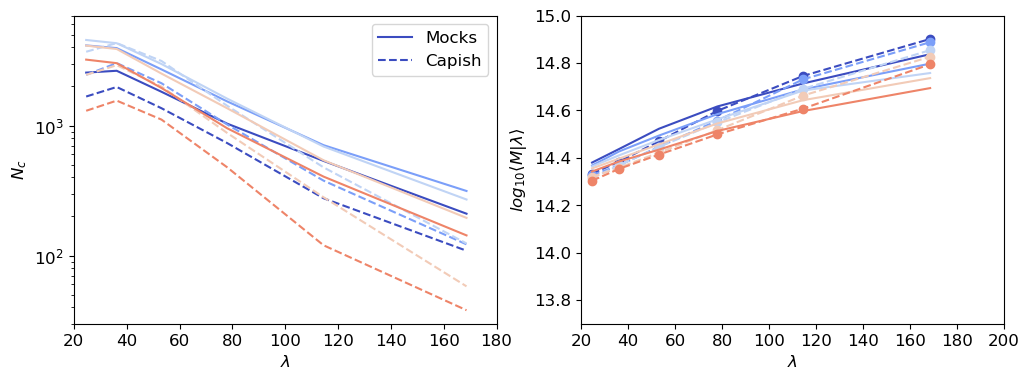

In [370]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)



for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    color = cmap(i /  len( pinocchio_mock['count_richness_redshift'].T ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                  pinocchio_mock['count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters.T[i] , '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                  pinocchio_mock['count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters.T[i] , '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(122)

for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    color = cmap(i /  len( pinocchio_mock['count_richness_redshift'].T ) ) 
    plt.plot( richness_cents , 
              np.log10( pinocchio_mock['mean_mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean.T[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

In [235]:
sim_mwl_mean

array([[14.29690837, 14.29540805, 14.29473797, 14.28945975, 14.28236805],
       [14.34833689, 14.34467585, 14.33655036, 14.33371139, 14.32849114],
       [14.44854769, 14.43891456, 14.42534381, 14.41687466, 14.40739413],
       [14.57910743, 14.57283173, 14.56108406, 14.53964145, 14.5454515 ],
       [14.71826496, 14.71492679, 14.69905135, 14.68998822, 14.68218381],
       [14.89549014, 14.87139588, 14.84965265, 14.85448622, 14.81406249]])

In [236]:
sim_n_clusters

array([[1937., 2871., 4444., 2955., 1652.],
       [2828., 4274., 6169., 3999., 2222.],
       [2079., 3194., 4431., 2702., 1448.],
       [1151., 1548., 2019., 1153.,  559.],
       [ 522.,  633.,  732.,  377.,  168.],
       [ 198.,  213.,  217.,  108.,   38.]])